In [129]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns

In [105]:
# Load data
df = pd.read_csv('subscription_events.csv', parse_dates=['event_timestamp'])

## Обраний підхід

- Дані розбито на місячні когорти за першим платіжним івентом.
- Для кожної когорти обчислено фактичний LTV за 6 місяців.
- Предикт на пів року побудовано за допомогою лінійної регресії (окремо для кожної когорти).
- Результати нормалізовано відносно LTV місяця з когортним івентом і візуалізовано у вигляді heatmap.

### Розрахунок фактичного LTV

In [106]:
# Filter purchase events and define first purchase per user
purchase_df = df[df['event_name'] == 'purchase'].copy()
first_pay = (
    purchase_df
    .groupby('uuid', as_index=False)['event_timestamp']
    .min()
    .rename(columns={'event_timestamp': 'first_purchase_ts'})
)
# Monthly cohort: first day of purchase month
first_pay['cohort_month'] = (
    first_pay['first_purchase_ts']
    .dt.to_period('M')
    .dt.to_timestamp()
)

# Merge cohorts and keep only events after first purchase
df = df.merge(
    first_pay[['uuid', 'first_purchase_ts', 'cohort_month']],
    on='uuid', how='inner'
)
df = df[df['event_timestamp'] >= df['first_purchase_ts']]

# Compute period index (months since cohort)
df['period_index'] = (
    (df['event_timestamp'].dt.year - df['cohort_month'].dt.year) * 12 +
    (df['event_timestamp'].dt.month - df['cohort_month'].dt.month)
)
# Keep only first 6 months (0–5)
df = df[df['period_index'].between(0, 5)]

# Aggregate revenue and compute actual cumulative LTV
cohort_revenue = (
    df.groupby(['cohort_month', 'period_index'], as_index=False)['revenue_usd']
    .sum().rename(columns={'revenue_usd': 'period_revenue'})
)
cohort_revenue['ltv_actual'] = (
    cohort_revenue.groupby('cohort_month')['period_revenue'].cumsum()
)

### Предикт LTV на пів року

In [107]:
# Forecast next 6 months per cohort using linear regression
H = 6
forecast_list = []
metrics_list = []
for cohort, grp in cohort_revenue.groupby('cohort_month'):
    grp = grp.sort_values('period_index')
    X = grp[['period_index']].values
    y = grp['ltv_actual'].values
    # Require at least two points to fit a line
    if len(X) < 2:
        continue
    model = LinearRegression()
    model.fit(X, y)
    # Evaluate training quality
    y_train_pred = model.predict(X)
    r2 = r2_score(y, y_train_pred)
    # compute RMSE via sqrt of MSE to avoid deprecated parameter
    rmse = np.sqrt(mean_squared_error(y, y_train_pred))
    metrics_list.append({'cohort_month': cohort, 'r2': r2, 'rmse': rmse})
    # Forecast future indices
    last_idx = grp['period_index'].max()
    future_idx = np.arange(last_idx + 1, last_idx + 1 + H).reshape(-1, 1)
    preds = model.predict(future_idx)
    df_pred = pd.DataFrame({
        'cohort_month': cohort,
        'period_index': future_idx.flatten(),
        'ltv_pred_linear': preds
    })
    forecast_list.append(df_pred)
# Combine forecasts and metrics
df_forecast = pd.concat(forecast_list, ignore_index=True) if forecast_list else pd.DataFrame(columns=['cohort_month','period_index','ltv_pred_linear'])
metrics_df = pd.DataFrame(metrics_list)

# Combine actual and predicted for visualization and analysis
ltv_combined = pd.concat([
    cohort_revenue[['cohort_month', 'period_index', 'ltv_actual']],
    df_forecast
], sort=False).sort_values(['cohort_month', 'period_index'])

In [108]:
# Print regression quality metrics
print("Training quality per cohort:")
print(metrics_df)

Training quality per cohort:
  cohort_month        r2         rmse
0   2023-03-01  0.969827  1167.352206
1   2023-04-01  0.967976   890.319709
2   2023-05-01  0.942661  1348.286931
3   2023-06-01  0.896256   537.013038
4   2023-07-01  0.889435    97.191893
5   2023-08-01  0.859300    68.135640
6   2023-09-01  0.869792    16.741392
7   2023-10-01  1.000000     0.000000


## Оцінка якості прогнозу

- **R² (якість моделі)**: у перших когортах (березень–травень) R² > 0.94 — модель добре відтворює як змінився LTV у перші місяці після покупки. Для нових когорт (липень і далі) R² нижчий через обмеженість історичних даних.
- **RMSE (середня помилка)**: для когорт із більшим revenue помилка висока (>1000), що може свідчити про завищені прогнози.
- **Лінійна форма**: модель передбачає постійне зростання LTV, але на практиці ріст часто сповільнюється — це може призводити до переоцінки.
- **Ризик для нових когорт**: у когорт із 1–2 місяцями історії прогноз на 6 місяців уперед може бути ненадійним.

In [109]:
# Pivot tables for actual and predicted
pivot_actual = (
    ltv_combined
    .pivot(index='cohort_month', columns='period_index', values='ltv_actual')
    .fillna(0)
)
pivot_pred = (
    ltv_combined
    .pivot(index='cohort_month', columns='period_index', values='ltv_pred_linear')
    .fillna(0)
)

In [110]:
print("Actual Cumulative LTV by Cohort (Months 0–5):")
print(pivot_actual.loc[:, 0:5])

Actual Cumulative LTV by Cohort (Months 0–5):
period_index           0            1            2            3            4  \
cohort_month                                                                   
2023-03-01    5428.92897  11112.23030  16119.79905  19812.81664  22719.00655   
2023-04-01    3785.92393   8118.26571  11788.53913  14537.62781  16566.20557   
2023-05-01    5613.67306  11141.71584  15514.81486  18406.50028  20501.00967   
2023-06-01    2057.97235   3926.93106   5279.23108   6090.24496   6626.81956   
2023-07-01     381.18617    753.10946   1000.20946   1143.25051   1160.73051   
2023-08-01     269.44736    551.79939    709.05939    719.04939      0.00000   
2023-09-01     134.69000    223.19771    240.67771      0.00000      0.00000   
2023-10-01      84.89000    104.87000      0.00000      0.00000      0.00000   

period_index            5  
cohort_month               
2023-03-01    24852.64691  
2023-04-01    18230.45288  
2023-05-01    21826.98741  
2023-06-01   

In [111]:
print("\nPredicted Cumulative LTV by Cohort (Months 6–11):")
print(pivot_pred.loc[:, 6:11])


Predicted Cumulative LTV by Cohort (Months 6–11):
period_index            6             7             8             9   \
cohort_month                                                           
2023-03-01    30237.431674  34112.629847  37987.828019  41863.026192   
2023-04-01    22202.724473  25068.883130  27935.041788  30801.200445   
2023-05-01    26704.397386  29905.429919  33106.462452  36307.494985   
2023-06-01     8355.870598   9280.091602  10204.312605  11128.533609   
2023-07-01     1667.389114   1862.312087   2057.235060   2252.158033   
2023-08-01     1240.068623   1390.675232   1541.281841   1691.888450   
2023-09-01      464.491082    517.484937    570.478792      0.000000   
2023-10-01      204.770000    224.750000      0.000000      0.000000   

period_index            10            11  
cohort_month                              
2023-03-01    45738.224364  49613.422537  
2023-04-01    33667.359102  36533.517760  
2023-05-01    39508.527519  42709.560052  
2023-06-01   

In [116]:
# Calculate actual LTV as % of Month 0 :
percent_of_month0_actual = pivot_actual.div(pivot_actual[0], axis=0) * 100

# Round to integer and convert to string
pct_actual = percent_of_month0_actual.round(0).astype(int)
pct_actual = pct_actual.where(pct_actual != 0, "")        # zeros → empty
pct_actual_str = pct_actual.astype(str)

# Only append “%” where there is a non‐empty string
display_pct_actual = pct_actual_str.where(pct_actual_str == "", pct_actual_str + "%")

print("Actual Cumulative LTV:")
print(display_pct_actual.loc[:, 0:5])


Actual Cumulative LTV:
period_index     0     1     2     3     4     5
cohort_month                                    
2023-03-01    100%  205%  297%  365%  418%  458%
2023-04-01    100%  214%  311%  384%  438%  482%
2023-05-01    100%  198%  276%  328%  365%  389%
2023-06-01    100%  191%  257%  296%  322%  328%
2023-07-01    100%  198%  262%  300%  305%      
2023-08-01    100%  205%  263%  267%            
2023-09-01    100%  166%  179%                  
2023-10-01    100%  124%                        


In [117]:
# Calculate forecast as % of Month 0 (baseline from actual LTV in period 0)
percent_of_month0_pred = pivot_pred.div(pivot_actual[0], axis=0) * 100

pct_pred = percent_of_month0_pred.round(0).astype(int)
pct_pred = pct_pred.where(pct_pred != 0, "")
pct_pred_str = pct_pred.astype(str)

display_pct_pred = pct_pred_str.where(pct_pred_str == "", pct_pred_str + "%")

print("\nPredicted Cumulative LTV:")
print(display_pct_pred.loc[:, 6:11])


Predicted Cumulative LTV:
period_index    6     7     8     9     10    11
cohort_month                                    
2023-03-01    557%  628%  700%  771%  842%  914%
2023-04-01    586%  662%  738%  814%  889%  965%
2023-05-01    476%  533%  590%  647%  704%  761%
2023-06-01    406%  451%  496%  541%  586%  631%
2023-07-01    437%  489%  540%  591%  642%      
2023-08-01    460%  516%  572%  628%            
2023-09-01    345%  384%  424%                  
2023-10-01    241%  265%                        


### Варіанти покращення прогнозу

1. **Нелінійні моделі**  
   Замість прямої лінії використати логарифмічну, поліном чи S-подібну функцію (через `curve_fit`).

2. **Валідація моделі**  
   Тренувати на періодах 0–4, перевіряти на місяці 5 — це покаже, наскільки модель точна для нових даних.

3. **LTV на одного користувача**  
   Додати розрахунок revenue per user для об'єктивного порівняння між когортами.

4. **Згладжування тренду**  
   Використати ковзне середнє або експоненційне згладжування, щоб прибрати шум перед побудовою моделі.

5. **Довірчі інтервали**  
   Додати межі невизначеності для прогнозу, наприклад через бутстреп.

6. **Обмеження для нових когорт**  
   Не прогнозувати 6 місяців для когорт із <2 періодами. Замість цього — орієнтовна оцінка на основі середнього приросту з інших когорт.


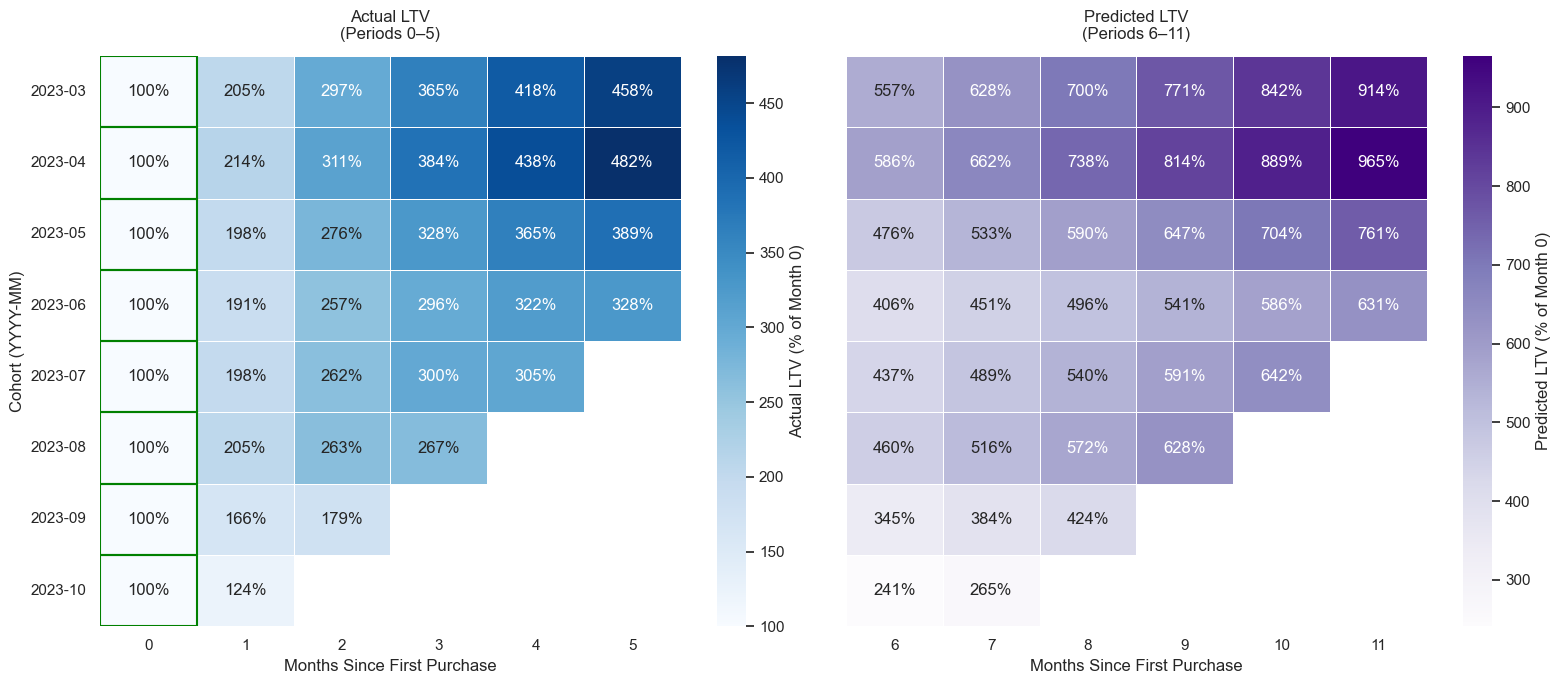

In [ ]:
# Plot Actual + Predicted heatmap
percent_of_month0_actual.index = pd.to_datetime(percent_of_month0_actual.index).strftime("%Y-%m")
percent_of_month0_pred.index = pd.to_datetime(percent_of_month0_pred.index).strftime("%Y-%m")

data_act = percent_of_month0_actual.loc[:, 0:5]
ann_act = display_pct_actual.loc[:, 0:5]
mask_act = data_act == 0
data_pred = percent_of_month0_pred.loc[:, 6:11]
ann_pred = display_pct_pred.loc[:, 6:11]
mask_pred = data_pred == 0

sns.set_theme(style="white")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7), sharey=True)

# Actual
sns.heatmap(
    data_act,
    mask=mask_act,
    cmap="Blues",
    annot=ann_act,
    fmt="",
    linewidths=0.5,
    linecolor="white",
    cbar_kws={"label": "Actual LTV (% of Month 0)"},
    ax=ax1
)

ax1.set_title("Actual LTV\n(Periods 0–5)", pad=12)
ax1.set_xlabel("Months Since First Purchase")
ax1.set_ylabel("Cohort (YYYY-MM)")
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0)
ax1.set_yticklabels(ax1.get_yticklabels(), rotation=0)

# Highlight 100%
for row in range(data_act.shape[0]):
    ax1.add_patch(
        Rectangle(
            (0, row),      # column 0, row row
            1, 1,          # 1 cell width height
            fill=False,
            edgecolor="green",
            linewidth=1.5
        )
    )

# Predicted
sns.heatmap(
    data_pred,
    mask=mask_pred,
    cmap="Purples",
    annot=ann_pred,
    fmt="",
    linewidths=0.5,
    linecolor="white",
    cbar_kws={"label": "Predicted LTV (% of Month 0)"},
    ax=ax2
)
ax2.set_title("Predicted LTV\n(Periods 6–11)", pad=12)
ax2.set_xlabel("Months Since First Purchase")
ax2.set_ylabel("")  # y-label не дублюється
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0)
ax2.set_yticklabels(ax1.get_yticklabels(), rotation=0)

plt.tight_layout()
plt.show()